In [1]:
import datetime
import random

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import mplfinance as mpf
import yfinance as yf

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from setup import get_task_data

SEED_VALUE = 42

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

2023-10-25 13:23:03.277616: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 13:23:03.324626: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-25 13:23:03.549070: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 13:23:03.549101: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 13:23:03.550847: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
financial_data = {}
metadata = {}

# Stocks have different IPO date (first trade) so only last ~3 years of data used
HISTORY_SIZE = 129
TARGET_STOCKS_COUNT = 5000

stocks_df = pd.read_csv(get_task_data("StocksList.csv"))

stocks_list = stocks_df['Symbol'].astype(str).to_list()
stocks_list = list(map(lambda s: s.replace('^', '-'), stocks_list))
random.shuffle(stocks_list)

stocks_list = stocks_list[:TARGET_STOCKS_COUNT]

tickers = stocks_list
tickers_df = yf.download(tickers, period='1y')

[*                      2%%                      ]  99 of 5000 completed

Failed to get ticker 'BF/A' reason: Expecting value: line 1 column 1 (char 0)


[*****                 10%%                      ]  486 of 5000 completed

Failed to get ticker 'CRD/B' reason: Expecting value: line 1 column 1 (char 0)


[******                13%%                      ]  659 of 5000 completed

Failed to get ticker 'AKO/A' reason: Expecting value: line 1 column 1 (char 0)


[***********           22%%                      ]  1120 of 5000 completed

Failed to get ticker 'WSO/B' reason: Expecting value: line 1 column 1 (char 0)


[*****************     35%%                      ]  1738 of 5000 completed

Failed to get ticker 'BRK/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************79%%************          ]  3963 of 5000 completed

Failed to get ticker 'CRD/A' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%%**********************]  5000 of 5000 completed


304 Failed downloads:
['WFC-C', 'GAB-G', 'GGT-E', 'GMRE-A', 'ACP-A', 'GLOP-C', 'EPR-C', 'AIG-A', 'CMRE-D', 'FHN-F', 'SR-A', 'ETX           ', 'BAC-M', 'AMH-H', 'NREF-A', 'C-K', 'TGH-B', 'JPM-K', 'PSA-L', 'BAC-N', 'GAB-H', 'PEB-F', 'RNR-F', 'BAC-E', 'RF-B', 'JPM-L', 'GNL-D', 'CSR-C', 'TFC-I', 'CNO-A', 'PRIF-J', 'PRIF-F', 'ECC           ', 'PSA-J', 'USB-Q', 'ATH-B', 'SCHW-J', 'ATCO-D', 'PRIF-D', 'SRG-A', 'SF-B', 'XFLT-A', 'SB-C', 'HT-C', 'CMRE-E', 'AMH-G', 'RWT-A', 'RITM-D', 'SNV-E', 'NS-C', 'NGL-C', 'MET-A', 'SCE-H', 'HL-B', 'AGM-D', 'YCBD-A', 'MITT-A', 'SCHW-D', 'AHT-I', 'EPR-G', 'ET-E', 'NLY-G', 'CHMI-A', 'OAK-A', 'RPT-D', 'MTB-H', 'VOYA-B', 'BEP-A', 'DRH-A', 'ECC-D', 'ACR-D', 'GS-K', 'RITM-C', 'REXR-B', 'OAK-B', 'MS-K', 'C-J', 'WAL-A', 'ICR-A', 'STT-D', 'GDV-K', 'AHT-F', 'AAIC-C', 'PEB-E', 'STT-G', 'RIV-A', 'CTA-A', 'HFRO-A', 'LXP-C', 'USB-A', 'NEE-R', 'SEAL-B', 'JPM-C', 'TRTN-A', 'LFT-A', 'ASB-F', 'SHO-I', 'NEE-N', 'GLP-A', 'NMK-C', 'GAM-B', 'CUBI-F', 'NS-A', 'ET-D', 'WFC-L', 'ALL-

In [3]:
tickers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 2022-10-25 00:00:00 to 2023-10-24 00:00:00
Columns: 30000 entries, ('Adj Close', 'A') to ('Volume', 'ZYME')
dtypes: float64(28388), int64(1612)
memory usage: 57.5+ MB


In [4]:
tickers_df = tickers_df.iloc[-HISTORY_SIZE:]

In [5]:
stocks_list[0]

'MCACW'

In [6]:
columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

def extract_history(tickers_df, stock):
    multiindex = pd.MultiIndex.from_product([columns, [stock]])
    stock_df = tickers_df[multiindex]

    stock_df.columns = stock_df.columns.to_flat_index()
    stock_df = stock_df.set_axis(columns, axis=1)
    stock_df = stock_df.dropna()
    return stock_df

Our financial data is supplied with metadata: name of a stock and financial sector it belongs too

Sectors:
* Technology - category of stocks relating to the research, development, or distribution of technologically based goods and services
* Basic Materials - category made up of businesses engaged in the discovery, development, and processing of raw materials 
* Communication Services - category made up of services such as social media companies, Internet search firms, video game makers, telecom providers, and streaming media make up most of this sector
* Consumer Cyclical - category of stocks that rely heavily on the business cycle and economic conditions. Consumer cyclicals include industries such as automotive, housing, entertainment, and retail
* Consumer Defensive - category of companies that manufacture food, beverages, household and personal products, packaging, or tobacco. Also includes companies that provide services such as education and training services
* Energy - category of companies that play a role in extracting, refining, or producing sources of energy
* Financial Services - category of firms and institutions that provide financial services to commercial and retail customers
* Healthcare - category of businesses that provide medical services, manufacture medical equipment or drugs, provide medical insurance, or otherwise facilitate the provision of healthcare to patients
* Industrials - category of businesses that aid other businesses in manufacturing, shipping or producing their products
* Real Estate - category of the following: Industrial, Office, Mixed-Industrial/Office, Retail-Shopping Centers, Retail-Regional Malls, Retail-Free Standing, Residential-Apartments, Residential-Manufactured Homes, Diversified, Lodging/Resorts, Health Care, Self Storage, Specialty, Home Financing and Commercial Financing
* Utilities - category of companies that provide their customers with electricity, water, and other public utilities

In [7]:
# metadata extraction is costly and not required for classification/regression

for stock in stocks_list:    
    history = extract_history(tickers_df, stock)
    
    if len(history) < HISTORY_SIZE:
        print(f"Too short history: {len(history)}")
        continue
    
    # ticker = yf.Ticker(stock)
    # sector = ticker.info.get('sector', None)

    # if not sector:
    #    print(f"No sector specified")
    #    continue

    financial_data[stock] = history
    # metadata[stock] = sector

Too short history: 1
Too short history: 0
Too short history: 0
Too short history: 1
Too short history: 1
Too short history: 107
Too short history: 0
Too short history: 0
Too short history: 30
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 47
Too short history: 0
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 0
Too short history: 0
Too short history: 0
Too short history: 16
Too short history: 0
Too short history: 1
Too short history: 1
Too short history: 1
Too short history: 123
Too short history: 0
Too short history: 1
Too short history: 123
Too short history: 10
Too short history: 0
Too short history: 1
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 1
Too short history: 1
Too short history: 51
Too short history: 1
Too short history: 1
Too short history: 0
To

In [8]:
len(financial_data)

4261

    1. Classification

Model that predicts if the next close value will be higher than current

RNN classification

In [9]:
def log_modified(n):
    if n == 0:
        return 0
    elif n < 0:
        return -np.log(-n)
    else:
        return np.log(n)

In [10]:
classification_stocks = []
classification_history = []
classification_target = []

for stock, data in financial_data.items():
    classification_stocks.append(stock)

    close_vals = data['Close'].to_numpy()
    close_vals_delta = np.diff(close_vals)
    close_vals_delta = np.insert(close_vals_delta, 0, 0)
    close_vals_delta_normalized = np.fromiter(map(lambda n: log_modified(n), close_vals_delta), dtype=np.float32)

    classification_history.append(close_vals_delta_normalized[0:HISTORY_SIZE - 1])
    classification_target.append(int(close_vals_delta_normalized[-1] > 0))

classification_data = {
    'Stock': classification_stocks,
    'History': classification_history,
    'Target': classification_target
}

In [11]:
classification_df = pd.DataFrame.from_dict(classification_data)

In [12]:
classification_df.sample(1)

,Stock,History,Target
3879,FANG,"[0.0, 0.87547255, -1.425516, -0.87547255, 0.12...",0


Values of close prices represented as a sequence and sector as one-hot vector

In [13]:
classification_train_df, classification_test_df = train_test_split(classification_df, test_size=0.2)

In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [15]:
classification_model = tf.keras.Sequential([
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True, input_shape=(None, (HISTORY_SIZE - 1))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense((HISTORY_SIZE - 1), activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense((HISTORY_SIZE - 1), activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [16]:
classification_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-6),
              metrics=[
                  'accuracy', 
                  # tfa.metrics.F1Score(average='macro', num_classes=1)
                ])

In [17]:
train_size = len(classification_train_df)
test_size = len(classification_test_df)

x_train = np.array(classification_train_df['History'].tolist()).reshape(train_size, 1, HISTORY_SIZE - 1)
y_train = np.array(classification_train_df['Target'].tolist()).reshape(train_size, 1)

x_test = np.array(classification_test_df['History'].tolist()).reshape(test_size, 1, HISTORY_SIZE - 1)
y_test = np.array(classification_test_df['Target'].tolist()).reshape(test_size, 1)

In [18]:
classification_history = classification_model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=500)

Epoch 1/500
107/107 [==============================] - 6s 17ms/step - loss: 2.8848 - accuracy: 0.6224 - val_loss: 2.3724 - val_accuracy: 0.6413
Epoch 2/500
107/107 [==============================] - 1s 8ms/step - loss: 2.4353 - accuracy: 0.6224 - val_loss: 2.2399 - val_accuracy: 0.6413
Epoch 3/500
107/107 [==============================] - 1s 8ms/step - loss: 2.3160 - accuracy: 0.6224 - val_loss: 2.1498 - val_accuracy: 0.6413
Epoch 4/500
107/107 [==============================] - 1s 8ms/step - loss: 2.2311 - accuracy: 0.6224 - val_loss: 2.0815 - val_accuracy: 0.6413
Epoch 5/500
107/107 [==============================] - 1s 8ms/step - loss: 2.1643 - accuracy: 0.6224 - val_loss: 2.0254 - val_accuracy: 0.6413
Epoch 6/500
107/107 [==============================] - 1s 8ms/step - loss: 2.1095 - accuracy: 0.6224 - val_loss: 1.9783 - val_accuracy: 0.6413
Epoch 7/500
107/107 [==============================] - 1s 8ms/step - loss: 2.0641 - accuracy: 0.6224 - val_loss: 1.9373 - val_accuracy: 0.641

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = classification_model.evaluate(x=x_test, y=y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2)
    fig.tight_layout(pad=5.0)

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_ylim([0, 1])

    ax[1].plot(history.history['loss'], label='accuracy')
    ax[1].plot(history.history['val_loss'], label='val_accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_ylim([0, 5])

    plt.show()

In [ ]:
plot_history(classification_history)

In [29]:
AGG_FUNCS = {
    col : ['mean', 'std', 'median'] for col in columns
}

def aggregate_stock(stock_df: pd.DataFrame, name: str) -> pd.DataFrame:
    
    for column in columns:
        stock_df[f'{column}_mean'] = stock_df[column].mean()
        stock_df[f'{column}_std'] = stock_df[column].std(ddof=0)
        stock_df[f'{column}_median'] = stock_df[column].median()
    stock_df = stock_df.head(1)
    stock_df.loc[:, 'Stock'] = [name]
    stock_df = stock_df.set_index('Stock').drop(columns, axis=1)
    return stock_df


def collect_financial_data(input_tickers: pd.DataFrame) -> pd.DataFrame: 
    aggregated_dfs = []
    for stock in stocks_list: 
        history = extract_history(input_tickers, stock)
        aggregated_stock = aggregate_stock(history, stock)
        aggregated_dfs.append(aggregated_stock)
    return pd.concat(aggregated_dfs, axis=0)

cluster_df = collect_financial_data(tickers_df)
cluster_df

/tmp/ipykernel_6889/2339533823.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df.loc[:, 'Stock'] = [name]
/tmp/ipykernel_6889/2339533823.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df.loc[:, 'Stock'] = [name]
/tmp/ipykernel_6889/2339533823.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

,Open_mean,Open_std,Open_median,High_mean,High_std,High_median,Low_mean,Low_std,Low_median,Close_mean,Close_std,Close_median,Adj Close_mean,Adj Close_std,Adj Close_median,Volume_mean,Volume_std,Volume_median
Stock,,,,,,,,,,,,,,,,,,
MCACW,0.000000,0.000000,0.000000,0.015100,0.000000,0.015100,0.015100,0.000000,0.015100,0.015100,0.000000,0.015100,0.015100,0.000000,0.015100,1.405210e+05,0.000000e+00,140521.0
BPT,5.956744,0.841198,5.740000,6.144031,0.885347,5.910000,5.743101,0.797448,5.460000,5.917519,0.839875,5.670000,5.917519,0.839875,5.670000,2.537682e+05,1.409978e+05,213300.0
DAC,64.744186,4.010081,66.040001,65.538294,3.944880,66.599998,63.987132,4.004781,65.459999,64.773798,3.973896,66.040001,64.773798,3.973896,66.040001,1.165341e+05,6.010505e+04,105600.0
COP,111.248140,8.971530,112.650002,112.467597,8.911420,114.599998,110.131473,8.932646,111.849998,111.261395,8.833633,113.419998,110.252423,9.366467,113.330002,5.159934e+06,2.127548e+06,4822200.0
STOK,8.002403,3.222902,6.740000,8.270775,3.373658,6.960000,7.742295,3.130030,6.320000,7.988140,3.252242,6.640000,7.988140,3.252242,6.640000,3.277132e+05,4.786033e+05,211900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASST,1.026558,0.507464,0.990000,1.105783,0.581133,1.030000,0.950054,0.457108,0.918000,1.005574,0.493510,0.960000,1.005574,0.493510,0.960000,1.150426e+06,8.061472e+06,68100.0
RGC,19.554721,4.482042,18.670000,19.993822,4.579644,19.040001,19.295178,4.490955,18.500000,19.600031,4.440037,18.670000,19.600031,4.440037,18.670000,1.488372e+03,2.305996e+03,600.0
EVV,9.203798,0.192088,9.210000,9.251163,0.191403,9.300000,9.160388,0.196691,9.180000,9.204109,0.195113,9.250000,8.968743,0.174581,8.960775,3.034140e+05,1.460766e+05,258700.0


2. Clusterization

Model that divides data into clusters, that expected to be close to it's sectors

Probably the best approach is to pack the vector of close values into matrix and clusterize them. 

/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


   cluster_label  Open_mean  Open_std  Open_median  High_mean  High_std  \
0              0       4210      4210         4210       4210      4210   
1              1         13        13           13         13        13   
2              2         59        59           59         59        59   
3              3        391       391          391        391       391   
4              4         23        23           23         23        23   

   High_median  Low_mean  Low_std  Low_median  Close_mean  Close_std  \
0         4210      4210     4210        4210        4210       4210   
1           13        13       13          13          13         13   
2           59        59       59          59          59         59   
3          391       391      391         391         391        391   
4           23        23       23          23          23         23   

   Close_median  Adj Close_mean  Adj Close_std  Adj Close_median  Volume_mean  \
0          4210            4210    

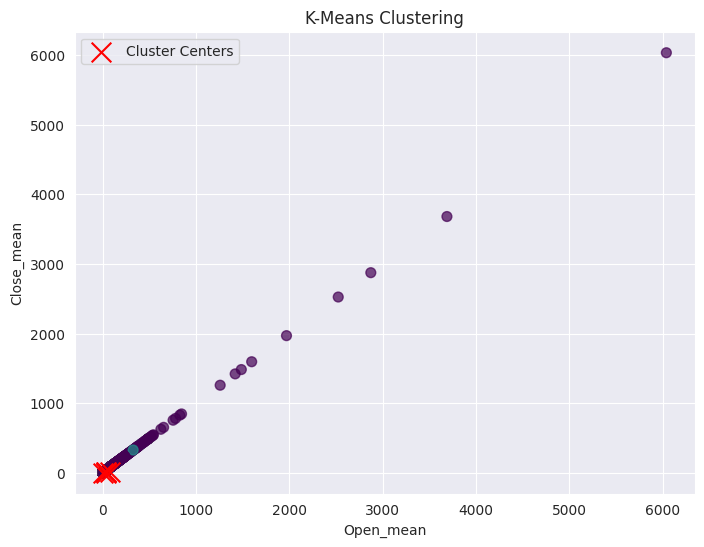

In [38]:
cluster_df = cluster_df.dropna()
kmeans = KMeans(n_clusters=5)
kmeans.fit(cluster_df)

cluster_df['cluster_label'] = kmeans.labels_

#probably compare by cartesian product
plt.figure(figsize=(8, 6))
plt.scatter(cluster_df['Open_mean'], cluster_df['Close_mean'], c=cluster_df['cluster_label'], cmap='viridis', s=50, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='x', label='Cluster Centers')

plt.title('K-Means Clustering')
plt.xlabel('Open_mean')
plt.ylabel('Close_mean')
plt.legend()

plt.show()

3. Regression

Model that predicts next close price of a stock given the sequence of previous trades

RNN regression

In [46]:
TARGET_TICKER = random.choice(stocks_list)
print(f'Selecting {TARGET_TICKER} story...')

def find_long_history():
    history = yf.download(TARGET_TICKER, period='100y')
    print(history)
    
regression_history = find_long_history()
regression_history

Selecting CAE story...
[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2002-07-29   6.650000   6.790000   6.600000   6.740000   5.220611   10800
2002-07-30   6.700000   6.800000   6.640000   6.640000   5.143157    8300
2002-07-31   6.610000   6.610000   6.350000   6.510000   5.042461    6700
2002-08-01   6.450000   6.450000   6.300000   6.300000   4.879800    3500
2002-08-02   6.310000   6.310000   6.310000   6.310000   4.887546     400
...               ...        ...        ...        ...        ...     ...
2023-10-18  22.530001  22.530001  21.500000  21.510000  21.510000  327300
2023-10-19  21.510000  21.600000  21.250000  21.400000  21.400000  324500
2023-10-20  21.370001  21.400000  20.760000  20.889999  20.889999  345000
2023-10-23  20.750000  21.110001  20.469999  20.840000  20.840000  557700
2023-10-24  21.09000

In [ ]:
regression_stocks = []
regression_history = []
regression_target = []

for stock, data in financial_data.items():
    classification_stocks.append(stock)

    close_vals = data['Close'].to_numpy()
    close_vals_delta = np.diff(close_vals)
    close_vals_delta = np.insert(close_vals_delta, 0, 0)
    close_vals_delta_normalized = np.fromiter(map(lambda n: log_modified(n), close_vals_delta), dtype=np.float32)

    classification_history.append(close_vals_delta_normalized[0:HISTORY_SIZE - 1])
    classification_target.append(int(close_vals_delta_normalized[-1] > 0))

classification_data = {
    'Stock': classification_stocks,
    'History': classification_history,
    'Target': classification_target
}